In [ ]:
import json
from matplotlib import pyplot as plt
import torch
from PIL import Image
from typing import Dict, List, Union, Tuple
import numpy as np
from matplotlib.axes import Axes
from math import prod

In [ ]:
with open("quality_control.json", "rb") as f:
    qc = json.load(f)

with open("quality/class_description.json", "rb") as f:
    cls2desc = json.load(f)

with open("quality/class_index.json", "rb") as f:
    cls2idx = json.load(f)

cls2desc = {k : v.strip().split(":")[0] for k, v in cls2desc.items()} 

print("Quality control output length (should be equal):\n", {k : len(v) for k, v in qc.items()})
# print(cls2desc)

def plot_ecdf(ax : Axes, arr : np.ndarray, hist : bool=True):
    x = np.sort(arr)
    y = np.arange(1, len(x) + 1) / len(x)
    ax.step(x, y, where='post')
    if hist:
        counts, bins = np.histogram(arr, min(100, max(10, len(arr) // 15)))
        counts = counts.astype(np.float64)
        counts /= counts.max()
        ax.stairs(counts, bins, fill=True)
        ax.set_ylabel("Cumulative & Relative density")
    else:
        ax.set_ylabel("Cumulative density")
    ax.set_xlabel("Confidence")

def reshape_ind(idx : np.ndarray, shape : Tuple[int, ...]):
    idx = idx.copy()
    out = np.zeros((len(idx), len(shape))).astype(idx.dtype)
    cp = [prod(shape[:i]) for i in range(len(shape))]
    for di in reversed(range(len(shape))):
        out[:, di] = idx // cp[di]
        idx -= cp[di] * out[:, di]
    if out.shape[1] == 1:
        out = out.reshape(len(out))
    return out

def spaced_ind_along(arr, im_per_cls):
    s = arr.shape
    n = prod(s)
    q = np.linspace(0, 1-1/n, im_per_cls, endpoint=True)
    i = np.round(q * n, decimals=0).astype(np.long)
    return reshape_ind(i, s)

def plot_qc(qc_result : Dict[str, List[Union[str, float, int]]], im_per_cls : int=4, conf_sort : bool=False):
    paths, clsl, conf = [qc_result[k] for k in ["path", "pred", "conf"]]
    conf = np.array(conf)
    clsv = np.array([cls2idx[cls] for cls in clsl])

    fig, axs = plt.subplots(len(cls2idx), (1+im_per_cls), figsize=((1+im_per_cls)*5, len(cls2idx)*3))
    # fig, axs = plt.subplots(len(cls2idx), 1, figsize=(5, 5*len(cls2idx)))

    for axi, cls in enumerate(sorted(list(cls2idx))):
        cm = clsv == cls2idx[cls]
        any_obs = bool(sum(cm) > 0)
        wi = np.where(cm)[0]
        if not any_obs:
            wi = np.zeros((im_per_cls, ))
        elif conf_sort:
            wi = wi[conf[cm].argsort(0)[::-1]][spaced_ind_along(wi, im_per_cls)]
        else:
            wi = wi[:im_per_cls]
        for axj, i in enumerate(wi, 1):
            if any_obs:
                im = Image.open(paths[i])
                ax = axs[axi, axj]
                ax.imshow(im)
                ax.set_title(f'{cls2desc[cls]} ({conf[i]:.1%})')
            ax.axis("off")
        if any_obs:
            plot_ecdf(axs[axi, 0], conf[cm], True)
plot_qc(qc, im_per_cls=20, conf_sort=True)
plt.tight_layout()
# plt.show()
plt.savefig("test_quality_control.jpg", dpi=300)
plt.close()

In [ ]:
num_valid_above_80 = sum([1 if qc["pred"][i] == "1" and qc["conf"][i] > 0.8 else 0 for i in range(len(qc["path"]))])
print(f'Found {num_valid_above_80} images classified as valid with above 80% confidence.\nThis corresponds to {num_valid_above_80/len(qc["path"]):.1%} of all images, or {num_valid_above_80/len([e for e in qc["pred"] if e == "1"]):.1%} of images classified as valid.')

In [ ]:
import json
from random import sample

import numpy as np
import torch
from PIL import Image

from mini_trainer.builders import base_model_builder

with open("quality/class_description.json", "rb") as f:
    cls2desc = {k : v.strip().split(":")[0] for k, v in json.load(f).items()}

with open("quality/class_index.json", "rb") as f:
    cls2idx = json.load(f)

sidxs = sample(range(len(qc["path"])), 5)
qc5 = {k : np.concat(smpl) if isinstance(v, np.ndarray) else smpl for k, v in qc.items() if (smpl := [v[i] for i in sidxs])}
idx2cls = {v : k for k, v in cls2idx.items()}

dev, dt = torch.device("cuda:0"), torch.float32

qcmodel, mproc = base_model_builder(
    model="efficientnet_v2_s",
    weights="quality/efficientnet_v2_s_full_e15.pt",
    device=dev,
    dtype=dt,
    fine_tune=False,
    num_classes=len(cls2desc)
)
qcmodel.eval()

def load_image(path):
    return mproc(torch.tensor(np.array(Image.open(path)).copy()).permute(2,0,1).float() / 255.)


with torch.inference_mode():
    with torch.autocast(dev.type, dt):
        tout = qcmodel(torch.stack([load_image(p) for p in qc5["path"]]).to(dev, dt)).cpu()
    tconfs = tout.softmax(1)
    tconf, tpred = tconfs.max(1).values, tout.argmax(1)
    tcls = [idx2cls[i.item()] for i in tpred]

for i in range(5):
    print("_"*60)
    print(f"PREDICTION #{i}")
    print(f"Model output: [{', '.join([f'{v:.1f}' for v in tout[i]])}]")
    print(f"Model confidences: [{', '.join([f'{c.item():.0%}' for c in tconfs[i]])}]")
    print(f"Model prediction & confidence: {cls2desc[tcls[i]]} ({tconf[i]:.1%})")

    print(f"Saved/Predicted confidence: {qc5["conf"][i]:.1%}/{tconf[i]:.1%}")
    print(f"Saved/Predicted class: {qc5["pred"][i]}/{tcls[i]}")
    print()
    print()

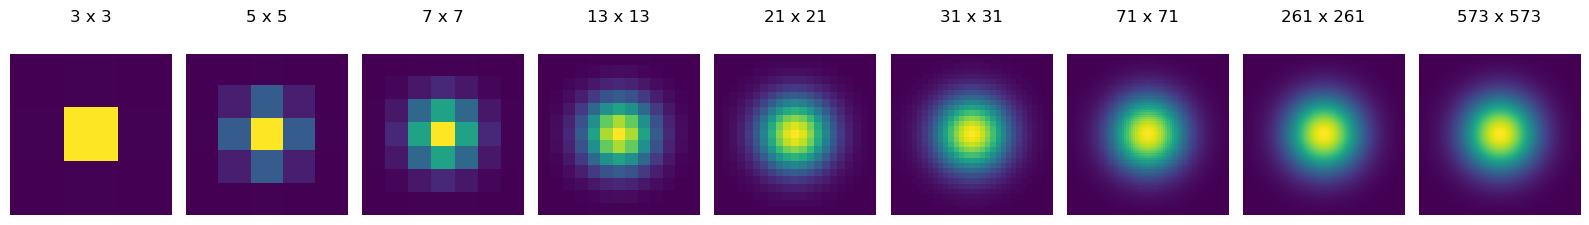

: 

In [ ]:
# Creates a gaussian kernel with the specified shape
def gk(shape):
    sran = torch.tensor([(d - 1) / 2. for d in shape]).unsqueeze(1)
    idx = torch.stack([t.flatten() for t in torch.meshgrid([torch.arange(d) for d in shape], indexing="ij")]).float()
    idx -= sran
    idx /= sran / torch.pi
    dens = torch.exp(-(idx ** 2).sum(0)/2)
    return dens.reshape(shape) / sum(dens)

fig, axs = plt.subplots(1, 9, figsize=(16, 2.25))

ks = [3, 5, 7, 13, 21, 31, 71, 261, 573]

for i, ax in enumerate(axs.flatten()):
    s = ks[i]
    ax.matshow(gk((s,s)))
    ax.axis("off")
    ax.set_title(f'{s} x {s}')
    ax.set_box_aspect(1)

plt.tight_layout()
plt.show()

NameError: name 'gk' is not defined

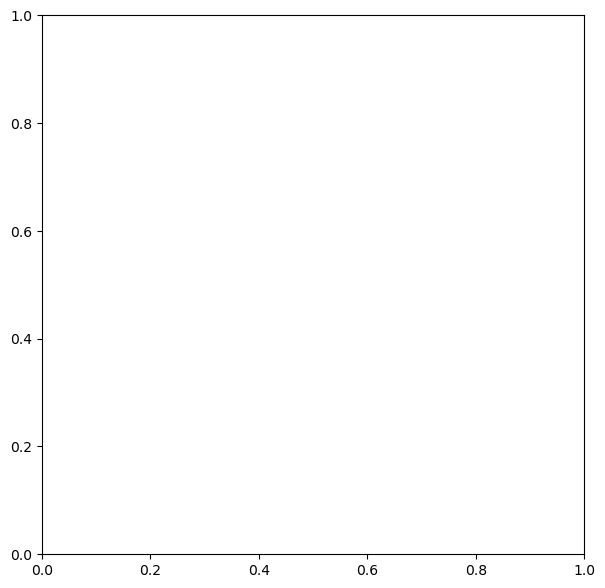

In [1]:
import numpy as np
import torch
from hierarchical.base.integration import (hierarchical_model_builder,
                                           hierarchical_parse_class_index)
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

dev, dt = torch.device("cuda:0"), torch.float32

model_builder_kwargs, other_args = hierarchical_parse_class_index("gmo_traits_class_index.json")
model, mproc = hierarchical_model_builder(
    model = "efficientnet_v2_s",
    weights = "hierarchical/gmo_traits.pt",
    fine_tune=False,    
    device=dev,
    dtype=dt,
    **model_builder_kwargs
)
model.eval()

masks = model_builder_kwargs["masks"]
cls2idx = other_args["class2idx"]
idx2cls = other_args["idx2class"]
gns = [row.nonzero().flatten().long() for row in (masks[0] + 100)]
fns = [row.nonzero().flatten().long() for row in (((masks[0] + 100)/100).T @ ((masks[1] + 100)/100).T).T]

llw = model.classifier.linear.weight.data.cpu().to(torch.float64)

llw -= llw.mean(dim = 1, keepdim=True)
llw /= llw.std(dim = 1, unbiased=True, keepdim=True)
llwn = llw.norm(2, dim=1)


cos_mat = (llw @ llw.T) / (llwn.unsqueeze(0) * llwn.unsqueeze(1))
eucl_mat = torch.cdist(llw, llw)
eucl_cdf_mat = torch.distributions.Chi2(llw.shape[1]).cdf((eucl_mat.cpu() ** 2 / 2))

# assume conf_mat (n×n) and cls_types are defined
cmap = plt.get_cmap('tab20')
n_types = len(fns)
colors = [cmap(i) for i in range(n_types)]
n_classes = eucl_cdf_mat.shape[0]

# build an RGBA list for each class
fam_colors = np.zeros((n_classes, 4))
for t, idxs in enumerate(fns):
    fam_colors[idxs] = colors[t]

gen_colors = np.zeros((n_classes, 4))
for t, idxs in enumerate(gns):
    gen_colors[idxs] = colors[t % len(colors)]

fig, ax = plt.subplots(figsize=(7, 7))

im = ax.matshow(torch.nn.functional.conv2d(eucl_cdf_mat.clone().float().unsqueeze(0).unsqueeze(0), gk((1,1,1,1))).reshape(*eucl_mat.shape).fill_diagonal_(torch.nan))
ax.axis("off")
plt.colorbar(im, ax=ax)

# shrink the heatmap to make room for the bars
bar_sz = 0.02
pos = ax.get_position()  # Bbox(x0, y0, width, height)
ax.set_position([
    pos.x0 + 1*bar_sz,
    pos.y0 + 1*bar_sz,
    pos.width - 1*bar_sz,
    pos.height - 1*bar_sz
])

# horizontal bar (just above the heatmap)
ax_top1 = fig.add_axes([
    pos.x0 + bar_sz,
    pos.y0 + pos.height,
    pos.width - bar_sz,
    bar_sz
])
ax_top1.imshow(fam_colors[None, :, :], aspect='auto')
ax_top1.axis('off')
ax_top2 = fig.add_axes([
    pos.x0 + bar_sz,
    pos.y0 + pos.height + bar_sz,
    pos.width - bar_sz,
    bar_sz
])
ax_top2.imshow(gen_colors[None, :, :], aspect='auto')
ax_top2.axis('off')

# vertical bar (just to the left of the heatmap)
ax_left1 = fig.add_axes([
    pos.x0,
    pos.y0 + bar_sz,
    bar_sz,
    pos.height - bar_sz
])
ax_left1.imshow(fam_colors[:, None, :], aspect='auto')
ax_left1.axis('off')
ax_left2 = fig.add_axes([
    pos.x0 - bar_sz,
    pos.y0 + bar_sz,
    bar_sz,
    pos.height - bar_sz
])
ax_left2.imshow(gen_colors[:, None, :], aspect='auto')
ax_left2.axis('off')

plt.show()

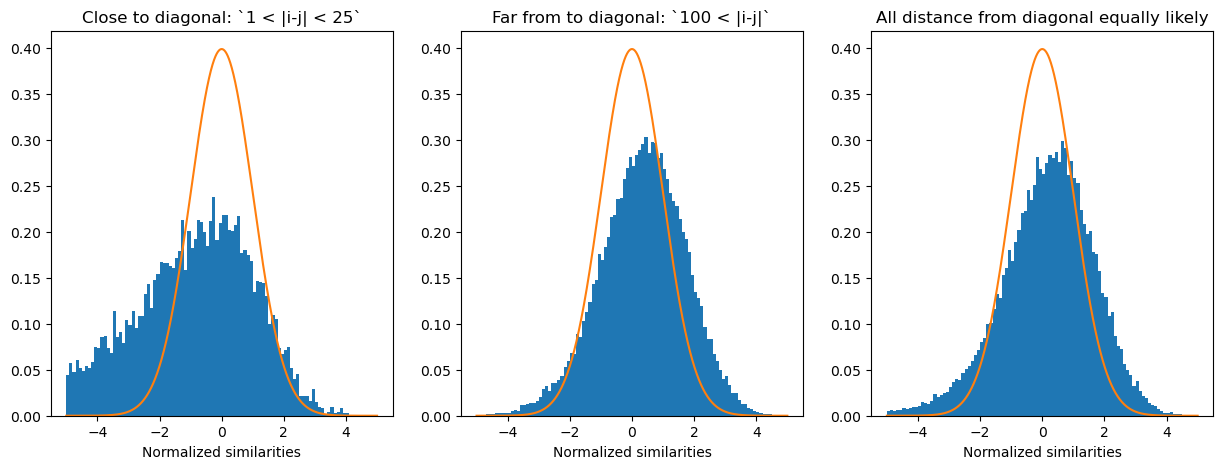

In [266]:
def plot_weighted_diag_hist(M, ax=None, bins=100, range=(-5, 5)):
    N = M.shape[0]
    v = M.ravel()
    idx = np.arange(N)
    d = np.abs(idx[:, None] - idx[None, :]).ravel()
    w = 1.0 / np.bincount(d, minlength=N)[d]
    if ax is None:
        fig, ax = plt.subplots()
    ax.hist(v, bins=bins, range=range, weights=w, density=True)
    return ax

eucl_mat_norm = torch.distributions.Normal(0, 1).icdf(eucl_cdf_mat.to(torch.float64))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ne_x, ne_y = torch.arange(-5, 5, 0.001), torch.distributions.Normal(0, 1).log_prob(torch.arange(-5, 5, 0.001)).exp()

ax1.hist(
    eucl_mat_norm[
        *torch.where(
            torch.logical_and(torch.tril(torch.ones_like(eucl_cdf_mat), -1), torch.logical_not(torch.tril(torch.ones_like(eucl_cdf_mat), -25)))
        )
    ].flatten(), 
    range=(-5, 5), bins=100, density=True
)
ax1.plot(ne_x, ne_y)
ax1.set_xlabel("Normalized similarities")
ax1.set_title("Close to diagonal: `1 < |i-j| < 25`")

ax2.hist(
    eucl_mat_norm[*torch.where(torch.tril(torch.ones_like(eucl_cdf_mat), -200))].flatten(), 
    range=(-5, 5), bins=100, density=True
)
ax2.plot(ne_x, ne_y)
ax2.set_xlabel("Normalized similarities")
ax2.set_title("Far from to diagonal: `100 < |i-j|`")

# ax3.hist(
#     eucl_mat_norm[*torch.where(torch.tril(torch.ones_like(eucl_cdf_mat), -1))].flatten(), 
#     range=(-6, 6), bins=100, density=True
# )
plot_weighted_diag_hist(
    eucl_mat_norm,
    ax3,
    bins=100,
    range=(-5,5)
)
ax3.plot(ne_x, ne_y)
ax3.set_xlabel("Normalized similarities")
ax3.set_title("All distance from diagonal equally likely")

plt.show()

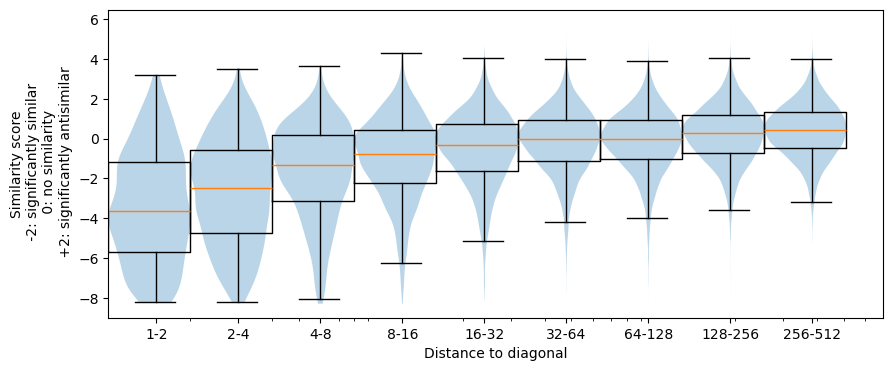

In [268]:
def plot_diag_distributions(M, bins=10, ax=None):
    N = M.shape[0]
    idx = np.arange(N)
    i_mat, j_mat = np.meshgrid(idx, idx, indexing='ij')
    mask = i_mat > j_mat                # lower triangle only, excludes diagonal
    d = (i_mat - j_mat)[mask]
    v = M[mask]

    edges = np.histogram_bin_edges(d, bins=bins)
    bin_idx = np.digitize(d, edges) - 1
    centers = 0.5 * (edges[:-1] + edges[1:])
    widths = np.diff(edges)
    groups, positions, widths_plot = [], [], []
    for k, (c, w) in enumerate(zip(centers, widths)):
        vals = v[bin_idx == k]
        vals = vals[np.isfinite(vals)]
        if vals.size == 0:
            continue
        if vals.size == 1:               # duplicate singletons so violin can render
            vals = np.concatenate([vals, vals])
        groups.append(vals)
        positions.append(c)
        widths_plot.append(w)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xscale("log")
    ax.violinplot(groups, positions=positions, widths=widths_plot, showextrema=False)
    ax.boxplot   (groups, positions=positions, widths=widths_plot, showfliers=False)
    ax.set_xlabel('Distance to diagonal')
    ax.set_ylabel('Similarity score\n -2: significantly similar\n 0: no similarity\n +2: significantly antisimilar')
    ax.set_xticks(centers, [f'{l}-{r}' if not can_round else f'{int(lr)}-{int(rr)}' for l, r in zip(edges[:-1], edges[1:]) if not isinstance(can_round := (np.isclose(l, lr := np.round(l)) and np.isclose(r, rr := np.round(r))), list)])
    return ax

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

plot_diag_distributions(
    eucl_mat_norm.clone().numpy(),
    2 ** np.arange(0, np.ceil(np.log2(len(eucl_mat_norm)))+1, 1),
    ax
)
pass

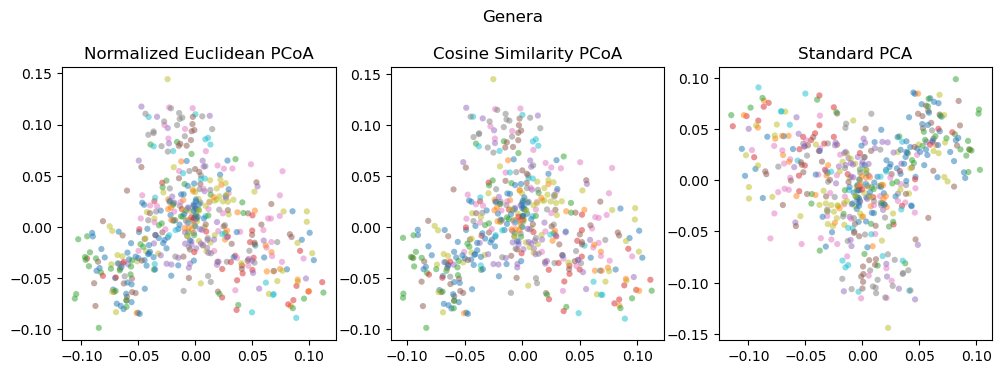

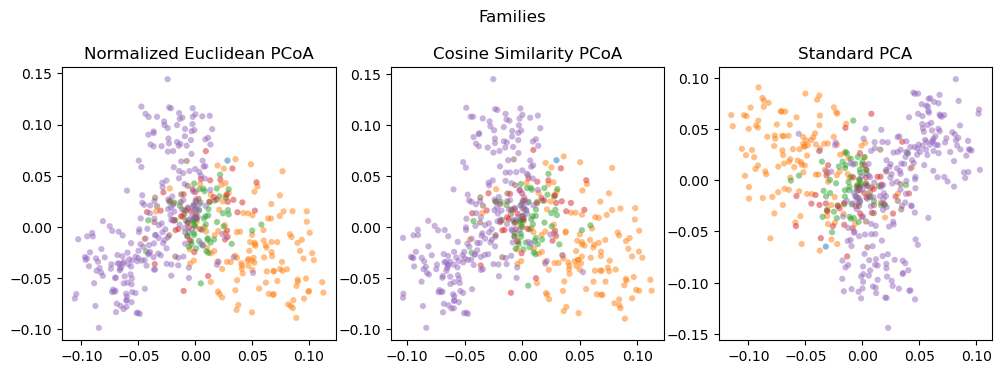

In [269]:
eucl_mat_norm_f = eucl_mat_norm.clone()
eucl_mat_norm_f[torch.logical_and(~torch.isfinite(eucl_mat_norm), eucl_mat_norm < 0)] = -10
eucl_mat_norm_f[torch.logical_and(~torch.isfinite(eucl_mat_norm), eucl_mat_norm > 0)] = 10
pxy_en = torch.svd_lowrank(eucl_mat_norm_f, 2, niter=100)[0].cpu()
pxy_cs = torch.svd_lowrank(cos_mat, 2, niter=100)[0].cpu()
pxy_st = torch.pca_lowrank(llw, 2, niter=100)[0].cpu()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

sc_args = {
    "s" : 20,
    "alpha" : 0.5,
    "edgecolors" : "none"
}

for gn in gns:
    ax1.scatter(*pxy_en[gn].T, **sc_args)
    ax1.set_box_aspect(1)
    ax2.scatter(*pxy_cs[gn].T, **sc_args)
    ax2.set_box_aspect(1)
    ax3.scatter(*pxy_st[gn].T, **sc_args)
    ax3.set_box_aspect(1)
ax1.set_title("Normalized Euclidean PCoA")
ax2.set_title("Cosine Similarity PCoA")
ax3.set_title("Standard PCA")

fig.suptitle("Genera")
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

for fn in fns:
    ax1.scatter(*pxy_en[fn].T, **sc_args)
    ax1.set_box_aspect(1)
    ax2.scatter(*pxy_cs[fn].T, **sc_args)
    ax2.set_box_aspect(1)
    ax3.scatter(*pxy_st[fn].T, **sc_args)
    ax3.set_box_aspect(1)
ax1.set_title("Normalized Euclidean PCoA")
ax2.set_title("Cosine Similarity PCoA")
ax3.set_title("Standard PCA")
fig.suptitle("Families")
plt.show()


{'1946661': {'family': ['6953', 'Hesperiidae'], 'genus': ['1946647', 'Borbo'], 'species': ['1946661', 'Borbo borbonica']}, '8277078': {'family': ['6953', 'Hesperiidae'], 'genus': ['1943357', 'Carcharodus'], 'species': ['8277078', 'Carcharodus alceae']}, '4535386': {'family': ['6953', 'Hesperiidae'], 'genus': ['1943357', 'Carcharodus'], 'species': ['4535386', 'Carcharodus baeticus']}, '1943397': {'family': ['6953', 'Hesperiidae'], 'genus': ['1943357', 'Carcharodus'], 'species': ['1943397', 'Carcharodus floccifera']}, '8178854': {'family': ['6953', 'Hesperiidae'], 'genus': ['1943357', 'Carcharodus'], 'species': ['8178854', 'Carcharodus lavatherae']}, '1943388': {'family': ['6953', 'Hesperiidae'], 'genus': ['1943357', 'Carcharodus'], 'species': ['1943388', 'Carcharodus stauderi']}, '1947335': {'family': ['6953', 'Hesperiidae'], 'genus': ['1947272', 'Carterocephalus'], 'species': ['1947335', 'Carterocephalus palaemon']}, '1947306': {'family': ['6953', 'Hesperiidae'], 'genus': ['1947272', '

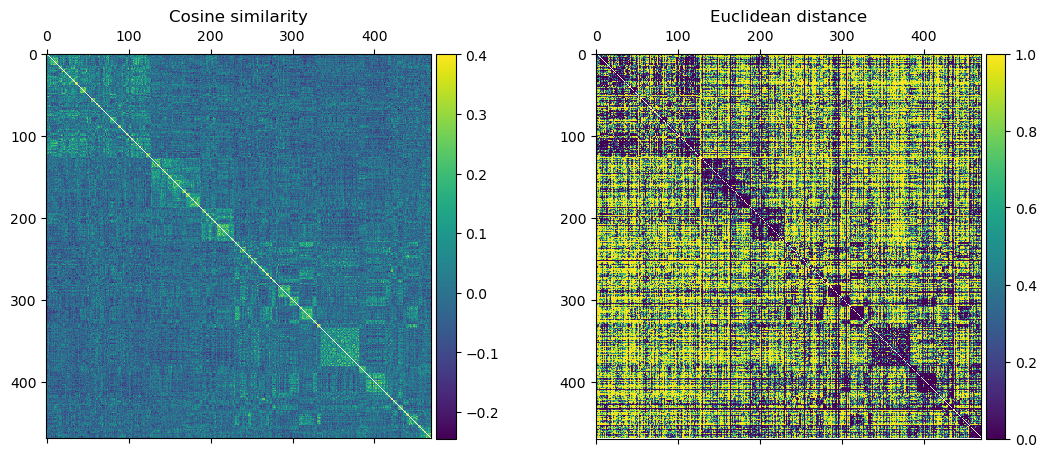

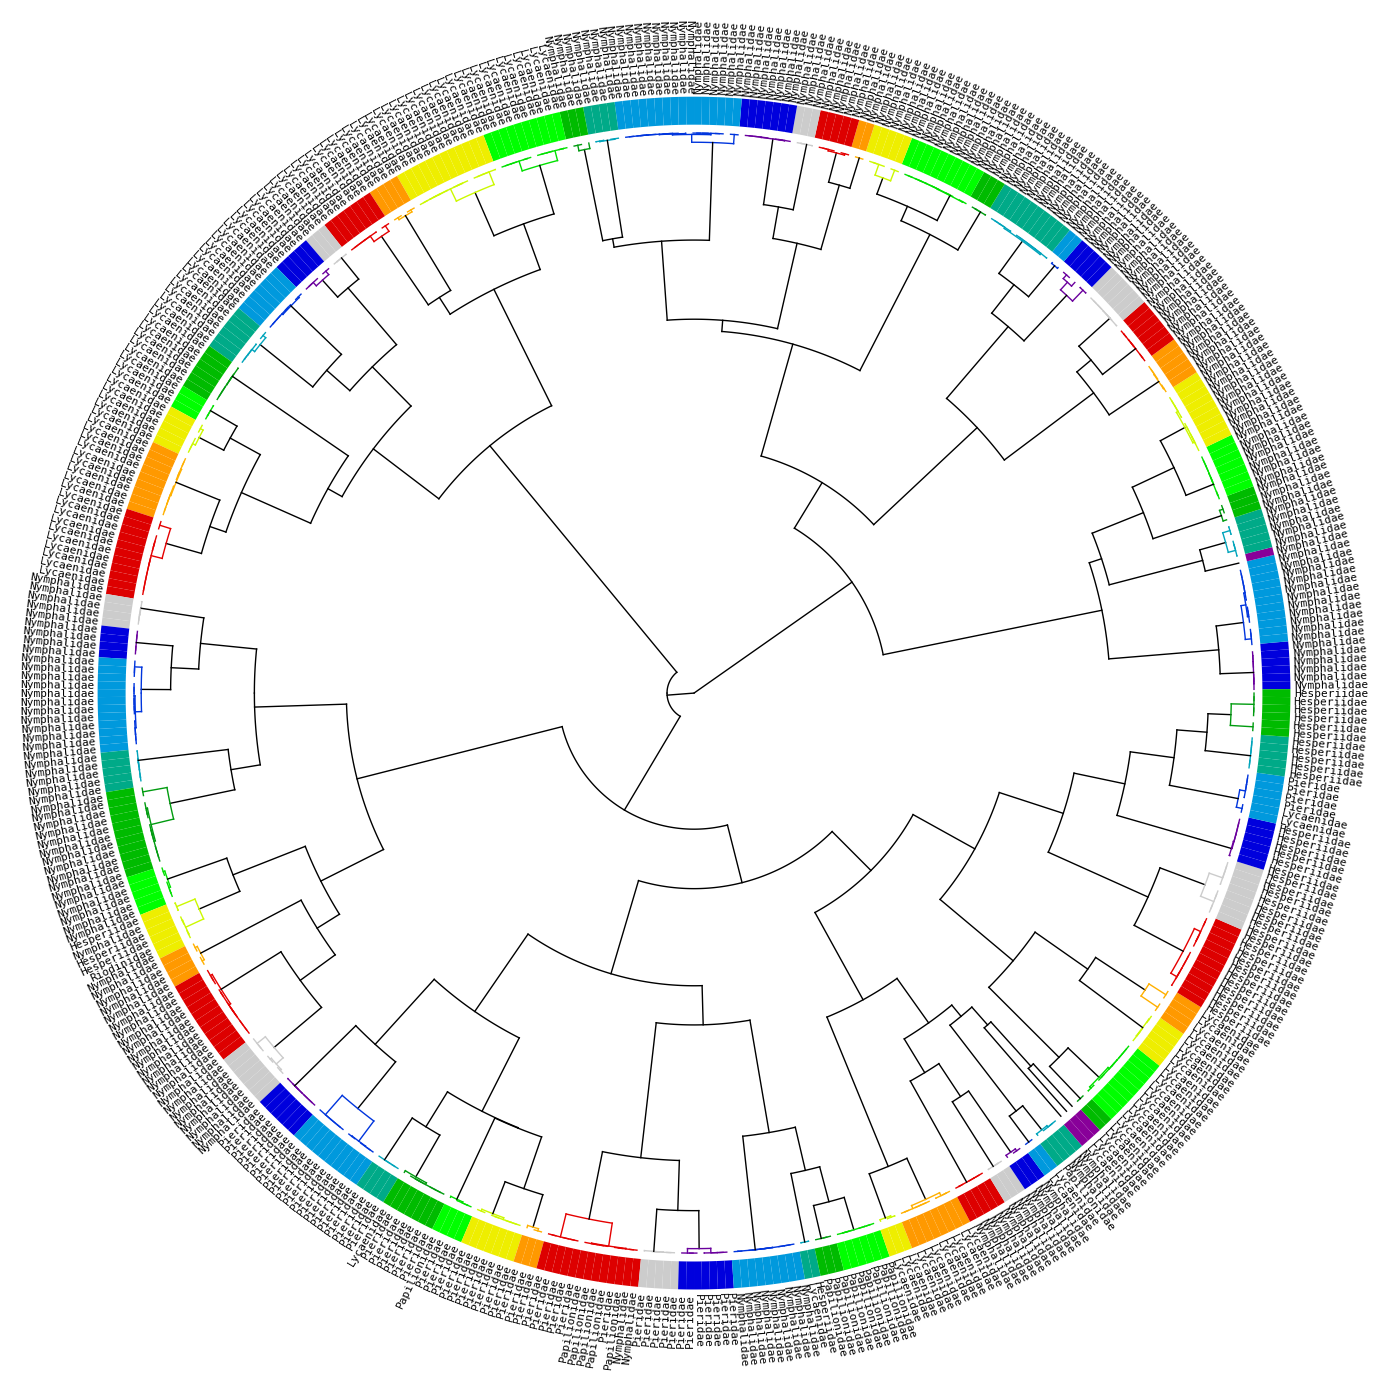

[347,
 336,
 373,
 371,
 272,
 351,
 361,
 374,
 377,
 362,
 259,
 343,
 364,
 370,
 345,
 365,
 379,
 348,
 342,
 353,
 363,
 340,
 422,
 358,
 366,
 368,
 355,
 376,
 359,
 380,
 341,
 344,
 356,
 339,
 369,
 381,
 350,
 360,
 375,
 337,
 346,
 357,
 238,
 419,
 240,
 237,
 242,
 258,
 283,
 290,
 294,
 284,
 289,
 286,
 288,
 297,
 291,
 287,
 296,
 415,
 417,
 285,
 414,
 416,
 230,
 418,
 431,
 430,
 432,
 434,
 433,
 435,
 293,
 278,
 277,
 279,
 327,
 326,
 329,
 300,
 303,
 307,
 398,
 302,
 304,
 295,
 305,
 229,
 292,
 306,
 308,
 299,
 298,
 301,
 354,
 420,
 328,
 330,
 367,
 372,
 378,
 338,
 349,
 352,
 400,
 280,
 412,
 392,
 411,
 395,
 410,
 391,
 404,
 401,
 406,
 394,
 393,
 408,
 407,
 397,
 403,
 409,
 413,
 399,
 405,
 396,
 402,
 250,
 256,
 251,
 254,
 276,
 252,
 255,
 111,
 113,
 34,
 30,
 31,
 123,
 125,
 122,
 124,
 126,
 73,
 108,
 17,
 19,
 116,
 32,
 33,
 70,
 104,
 105,
 18,
 100,
 16,
 119,
 25,
 74,
 45,
 47,
 42,
 44,
 46,
 43,
 48,
 77,
 64,
 65,
 20

In [ ]:
import sys
from importlib import util
from types import ModuleType
from pathlib import Path
import json

def import_module_from_folder(folder: str, module_name: str, package_name: str = None):
    """
    Dynamically imports a module from a folder that uses relative imports.

    :param folder: Path to the project folder (must contain __init__.py).
    :param module_name: Name of the .py file (without .py) to import.
    :param package_name: Package name to assign (defaults to folder name).
    :return: The imported module.
    """
    folder = Path(folder).resolve()
    pkg_name = package_name or folder.name

    # 1) Create and register the package
    pkg = ModuleType(pkg_name)
    pkg.__path__ = [str(folder)]
    sys.modules[pkg_name] = pkg

    # 2) Build spec for the submodule
    full_mod_name = f"{pkg_name}.{module_name}"
    file_path = folder / f"{module_name}.py"
    spec = util.spec_from_file_location(full_mod_name, str(file_path))

    # 3) Create, register, and execute the module
    mod = util.module_from_spec(spec)
    sys.modules[full_mod_name] = mod
    spec.loader.exec_module(mod)

    return mod

m = import_module_from_folder("/home/asger/structured-analysis", "plots")

with open("taxonomy_store.json", "rb") as f:
    taxonomy = json.load(f)
    species_labels = [taxonomy[idx2cls[2][i]]["family"][1] for i in range(len(idx2cls[2]))]

m.hierarchical_cluster_llw(model.classifier.linear.weight.data.cpu(), species_labels)